In [1]:
import csv
import cv2
import os
import numpy as np
import sklearn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline
samples = []
with open('My_trajectory2/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples,test_size=0.2)


def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:

            ## Center Camera
                center_cam = batch_sample[0].split(',')[-1]
                center_image = cv2.cvtColor(cv2.imread(center_cam),cv2.COLOR_BGR2RGB)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                images.append(cv2.flip(center_image,1))
                angles.append(center_angle)
                angles.append(center_angle*-1.0)
                
            ## Left Camera
                left_cam = batch_sample[1].split(',')[-1]
                left_image = cv2.cvtColor(cv2.imread(left_cam),cv2.COLOR_BGR2RGB)
                left_angle = center_angle + 0.35
                images.append(left_image)
                images.append(cv2.flip(left_image,1))
                angles.append(left_angle)
                angles.append(left_angle*-1.0)
                
            ## Right Camera
                right_cam =batch_sample[2].split(',')[-1]
                right_image = cv2.cvtColor(cv2.imread(right_cam),cv2.COLOR_BGR2RGB)
                right_angle = center_angle - 0.35
                images.append(right_image)
                images.append(cv2.flip(right_image,1))
                angles.append(right_angle)
                angles.append(right_angle*-1.0)
    
            
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# Set our batch size
batch_size=32

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)       

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)    

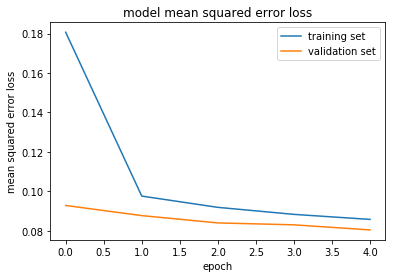

In [2]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda , Cropping2D, Dropout, Activation
from keras.layers import Reshape
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
import math
import matplotlib.pyplot as plt
%matplotlib inline


model = Sequential()

model.add(Lambda(lambda x: (x/ 177.5) - 0.5,input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25), (0,0))))

model.add(Conv2D(24,5,strides=(2, 2),activation='elu'))
model.add(Conv2D(36,5,strides=(2, 2),activation='elu'))
model.add(Conv2D(48,5,strides=(2, 2),activation='elu'))
model.add(Conv2D(64,3,activation='elu'))
model.add(Conv2D(64,3,activation='elu'))

model.add(Flatten())

model.add(Dropout(0.3))

model.add(Dense(100,activation = 'elu'))


model.add(Dropout(0.3))

model.add(Dense(50,activation = 'elu'))


model.add(Dropout(0.3))

model.add(Dense(10,activation = 'elu'))


model.add(Dense(1))

model.summary()

model.compile(loss = 'mse', optimizer = 'adam')

history_object = model.fit_generator(train_generator, 
            steps_per_epoch=math.ceil(len(train_samples)/batch_size), 
            validation_data=validation_generator, 
            validation_steps=math.ceil(len(validation_samples)/batch_size), 
            epochs=5, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [4]:
model.save('CarND-Behavioral-Cloning-P3-master/my_model2.h5')
print('Model Saved')

Model Saved
